In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

BATCH_START = 0
TIME_STEPS = 20
BATCH_SIZE = 50
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CELL_SIZE = 10
LR = 0.006


def get_batch():
    global BATCH_START, TIME_STEPS
    xs = np.arange(BATCH_START, BATCH_START+TIME_STEPS*BATCH_SIZE)\
                .reshape((BATCH_SIZE, TIME_STEPS))/(10*np.pi) 
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START += TIME_STEPS
    plt.plot(xs[0, :], res[0, :], 'r', xs[0, :], seq[0, :], 'b--')
    plt.show()
    return [seq[:,:,np.newaxis], res[:,:,np.newaxis], xs]

class LSTMRNN(object):
    def __init__(self, n_steps, input_size, output_size, cell_size, batch_size):
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size
        with tf.name_scope('inputs'):
            self.xs = tf.placeholder(tf.float32, [None, n_steps, input_size],name = 'xs')
            self.ys = tf.placeholder(tf.float32, [None, n_steps, output_size],name = 'ys')
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope("LSTM_cell"):
            self.add_cell()
        with tf.variable_scope()

C:\Users\liuliyian\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


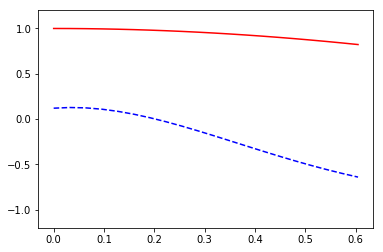

cost:  18.3054


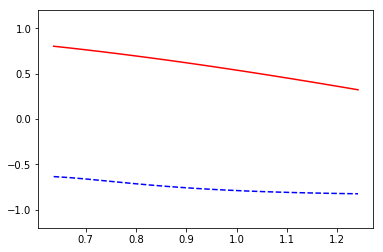

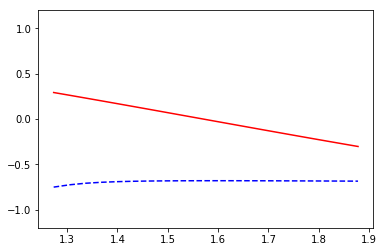

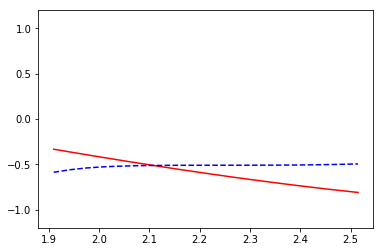

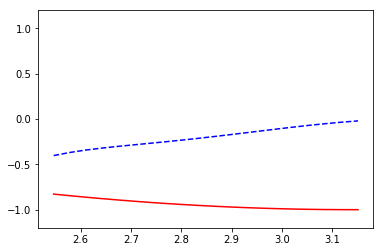

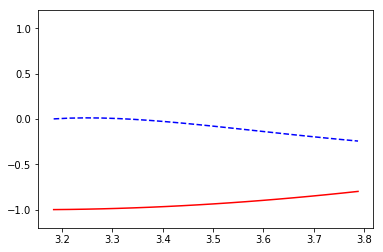

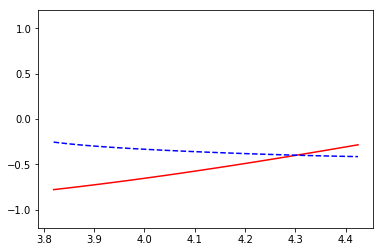

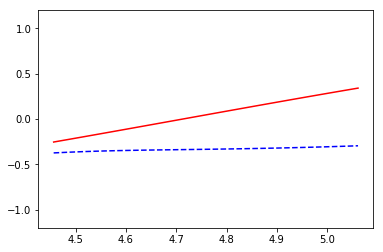

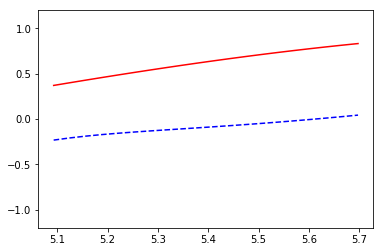

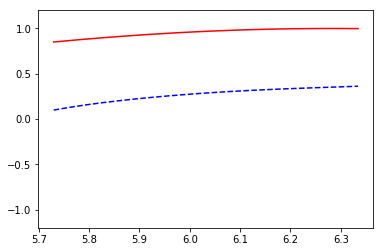

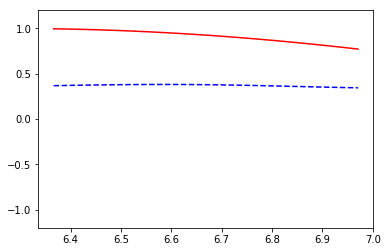

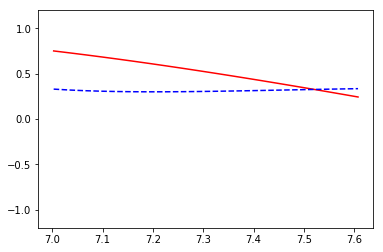

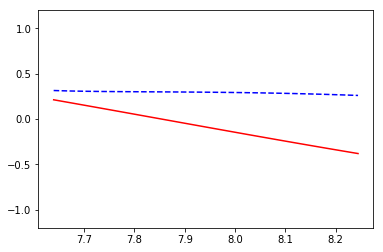

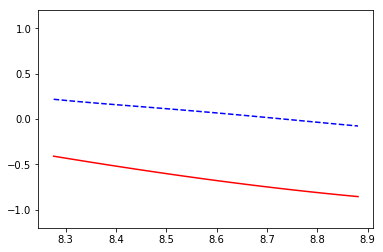

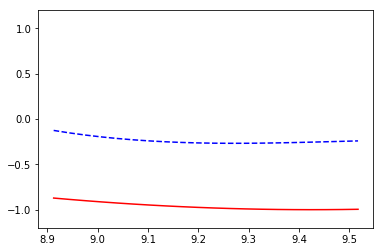

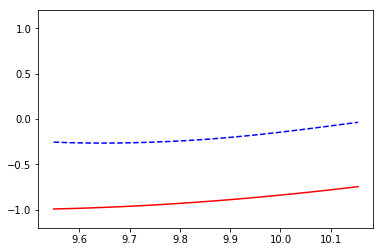

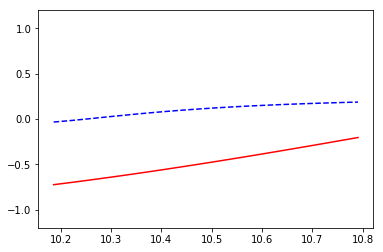

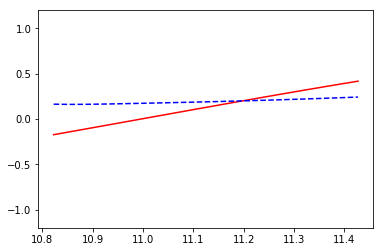

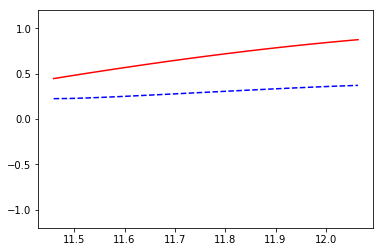

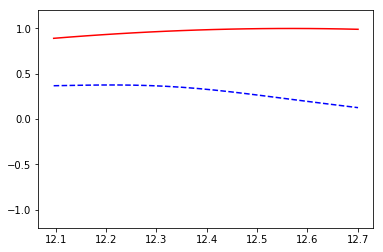

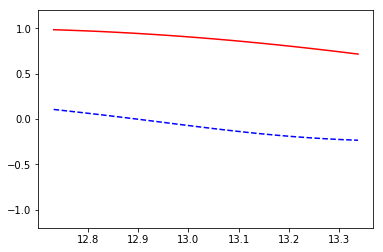

cost:  5.3311


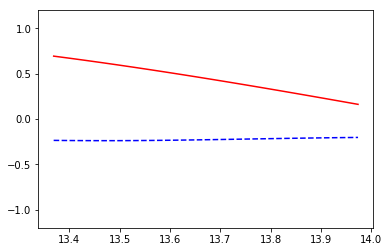

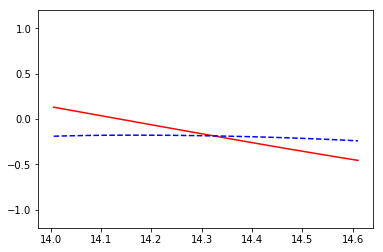

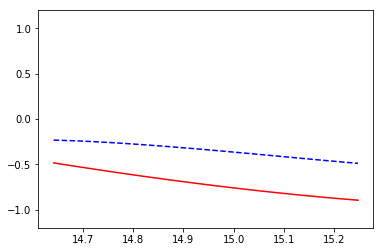

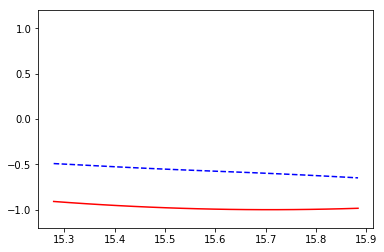

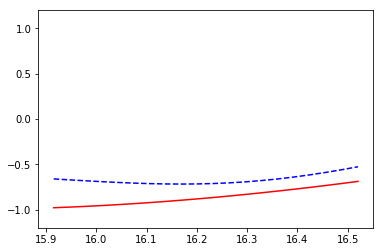

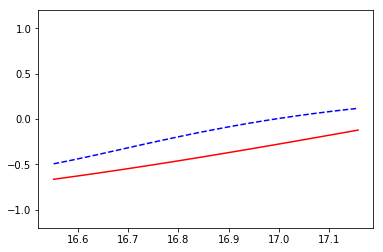

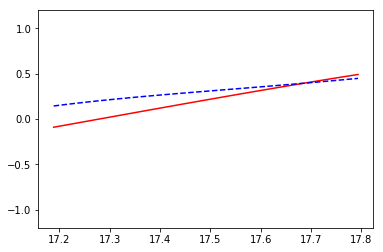

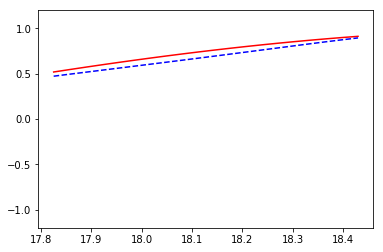

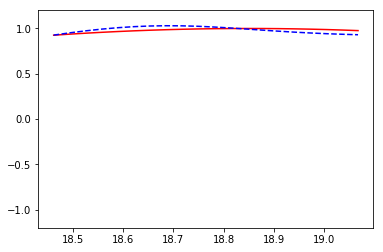

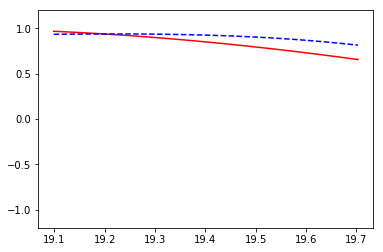

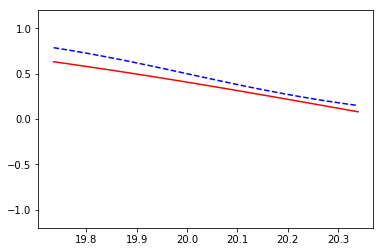

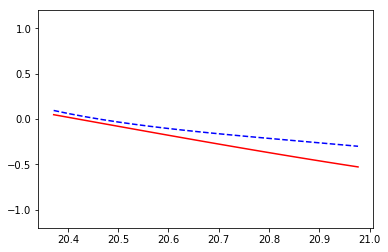

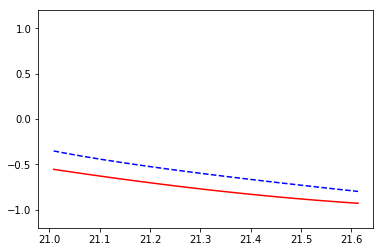

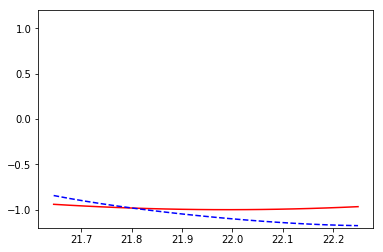

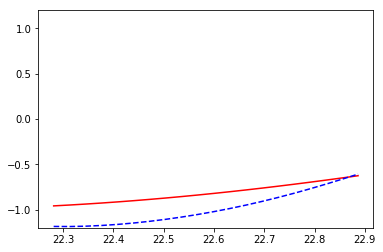

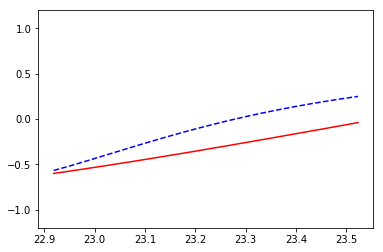

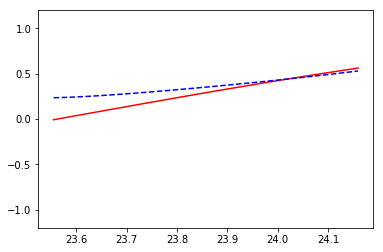

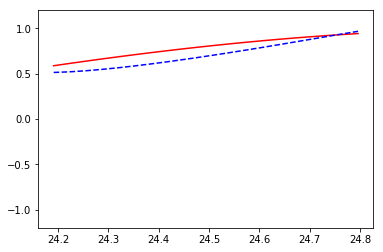

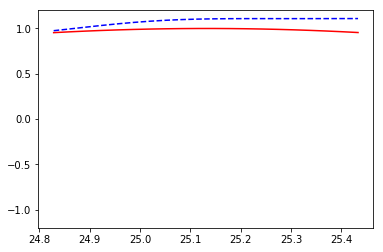

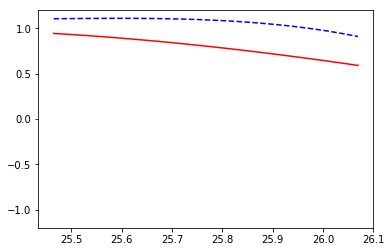

cost:  0.6696


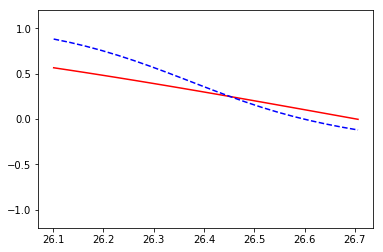

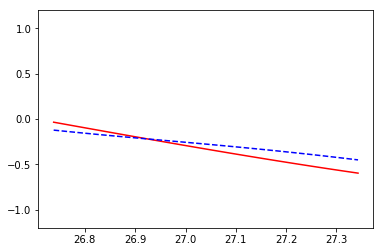

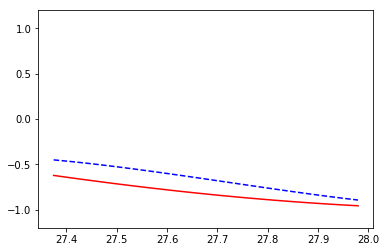

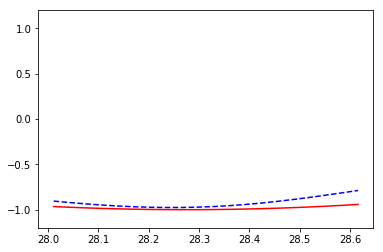

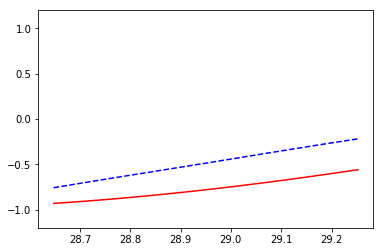

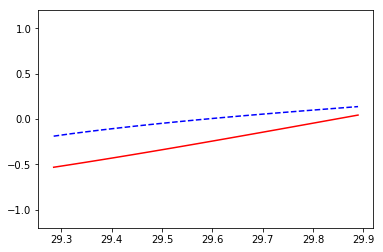

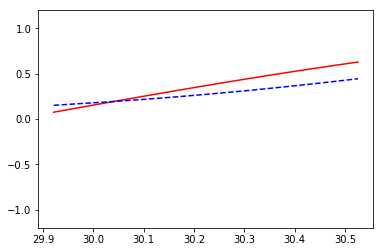

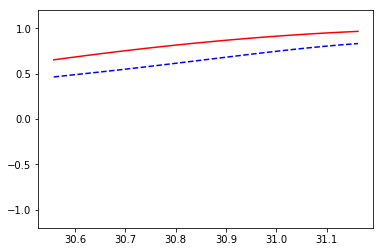

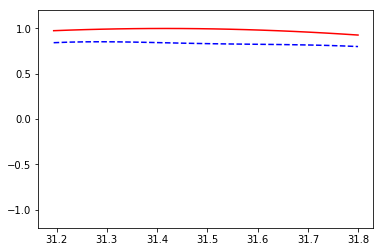

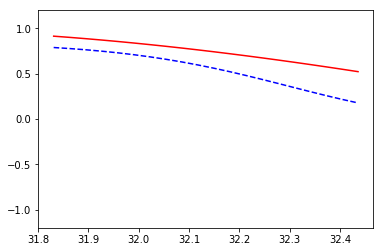

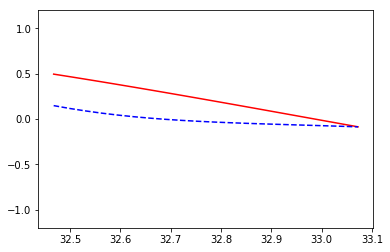

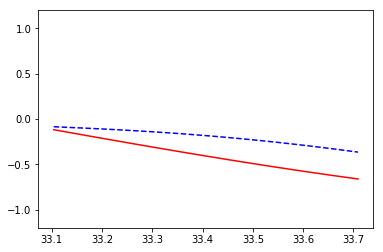

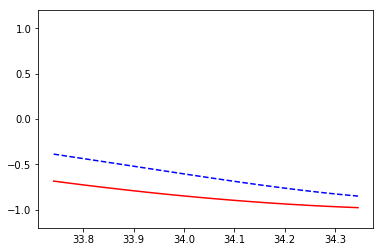

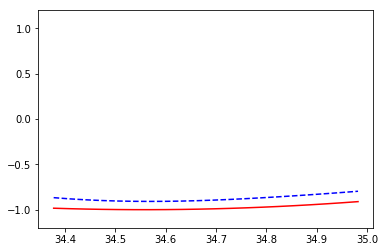

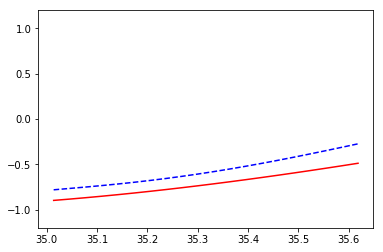

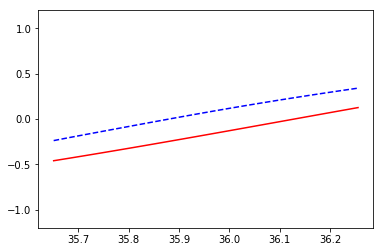

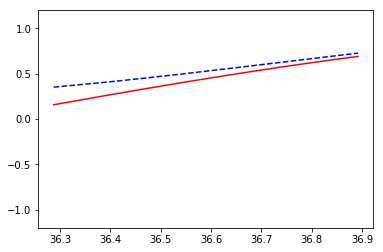

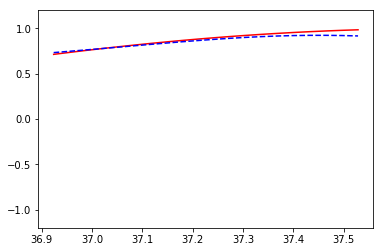

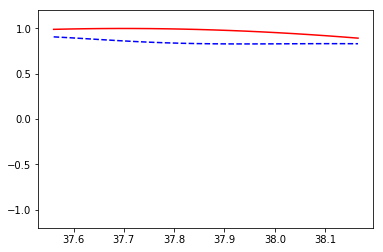

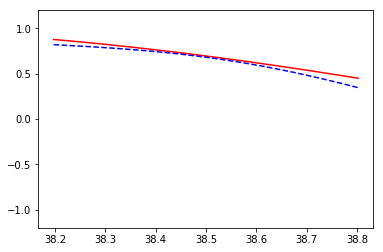

cost:  0.5219


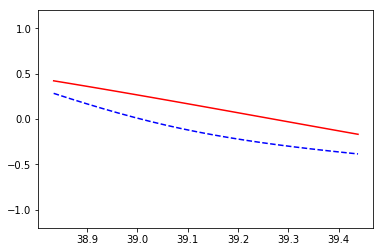

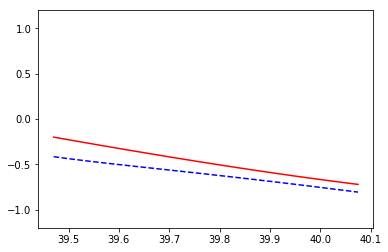

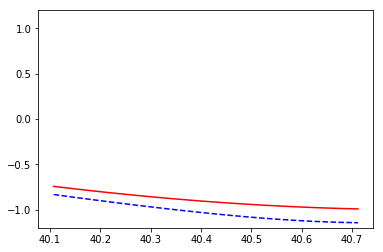

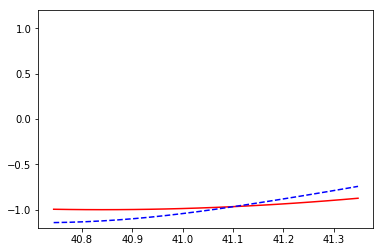

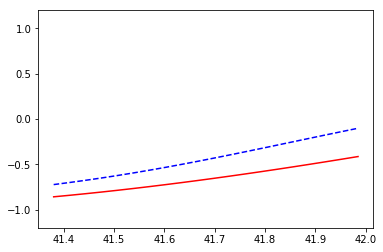

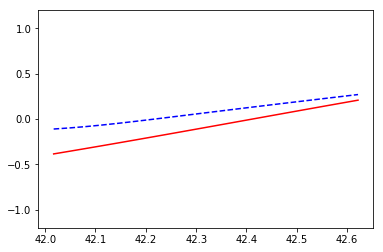

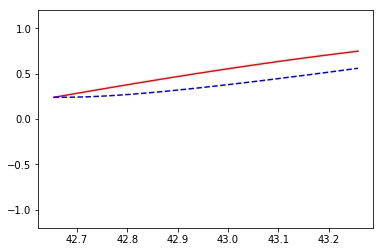

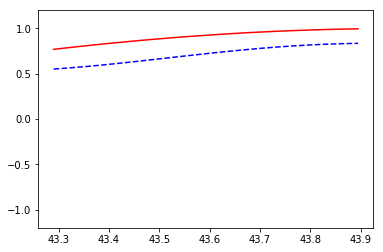

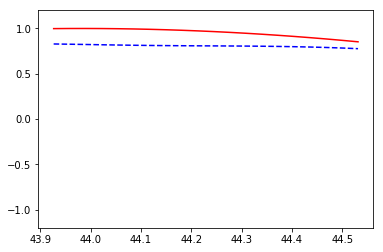

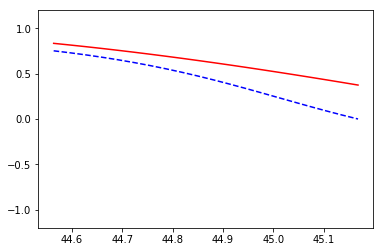

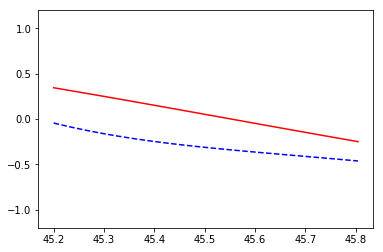

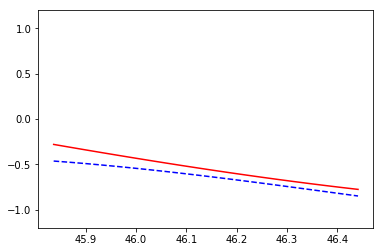

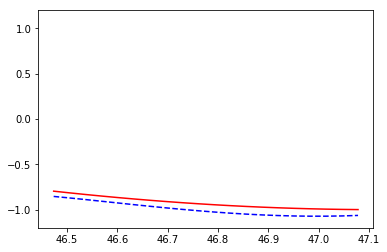

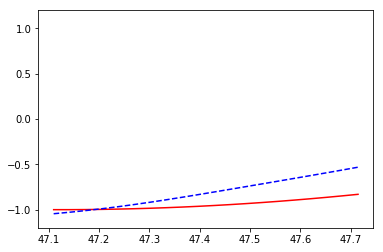

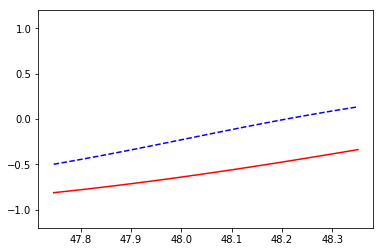

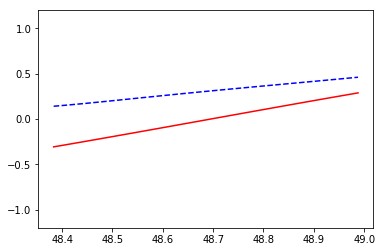

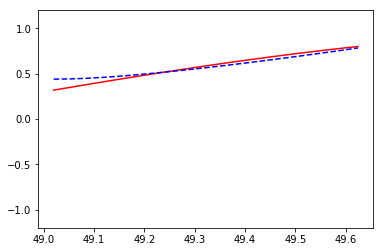

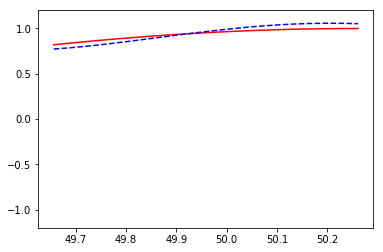

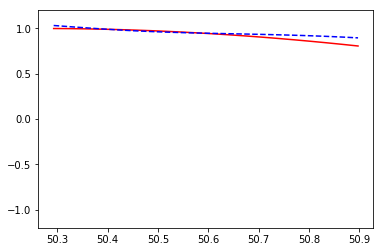

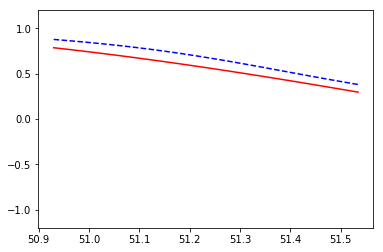

cost:  1.135


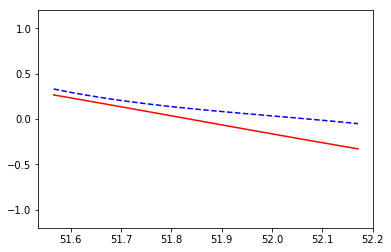

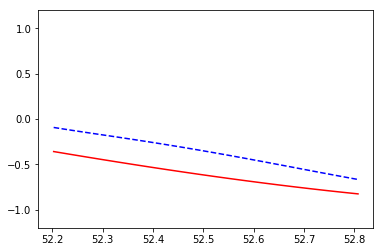

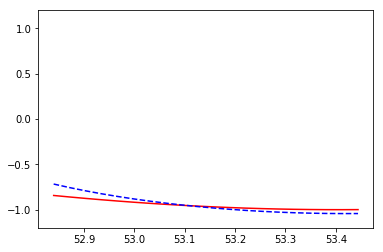

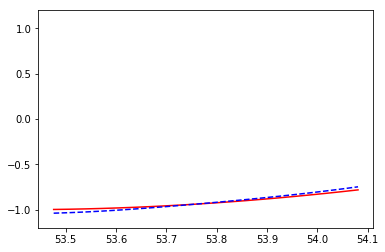

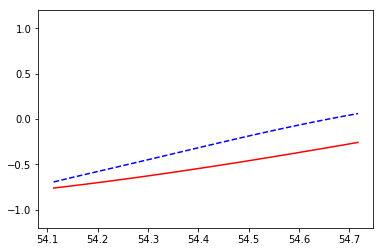

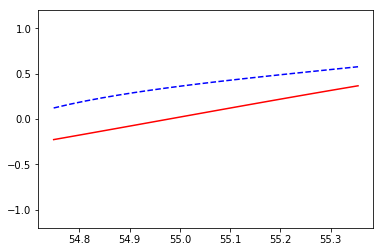

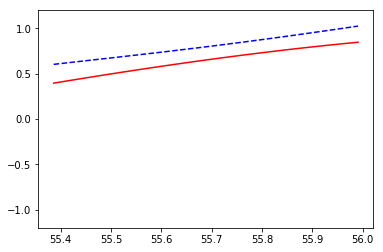

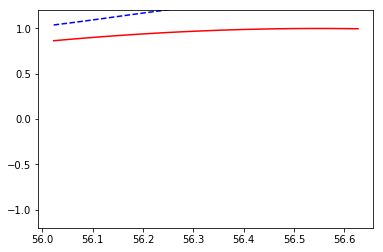

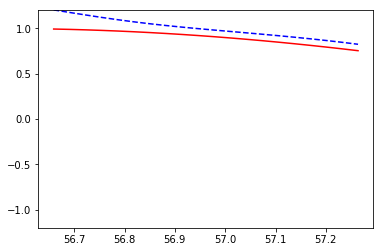

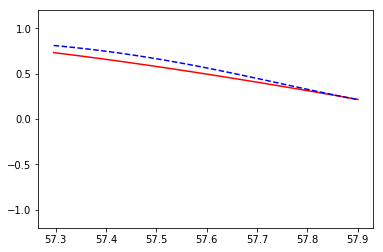

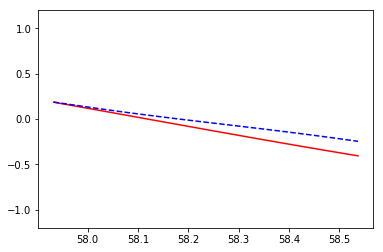

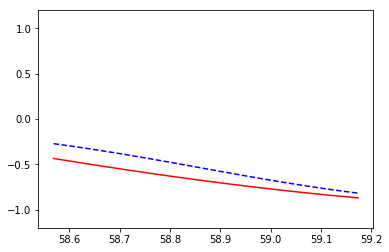

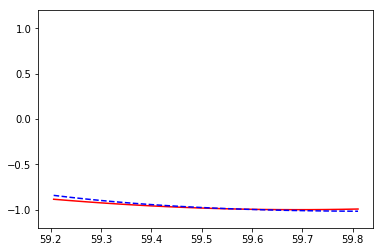

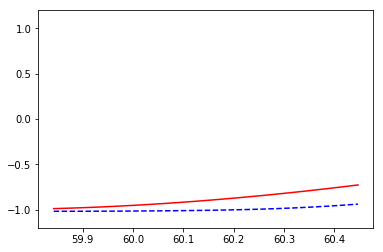

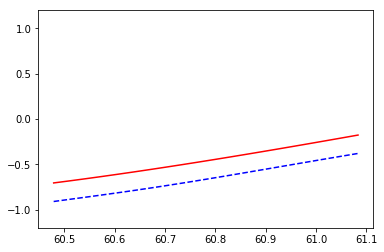

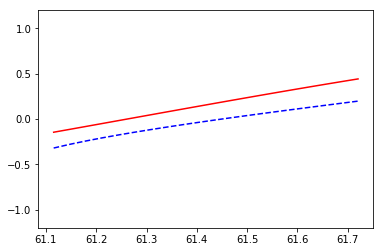

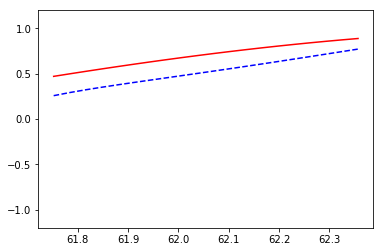

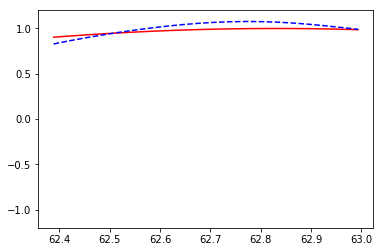

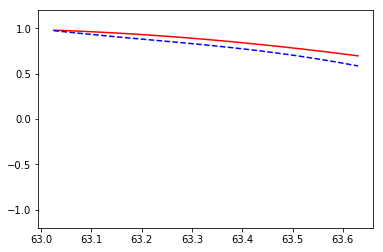

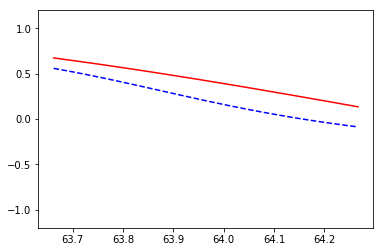

cost:  0.646


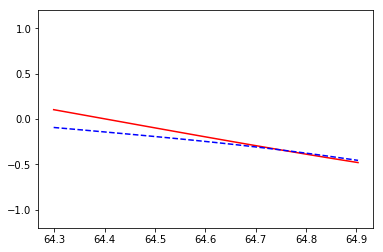

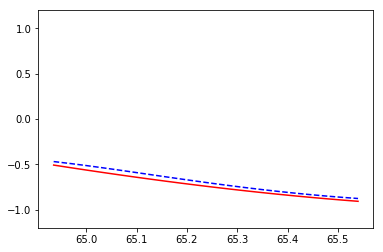

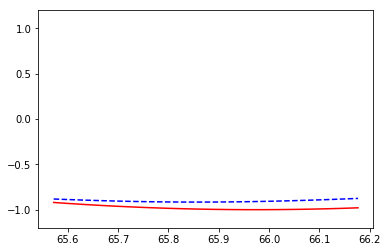

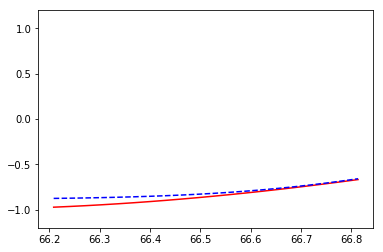

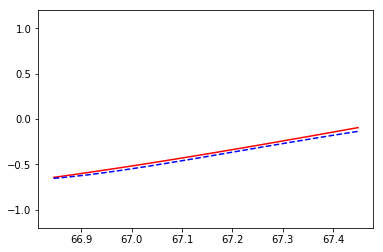

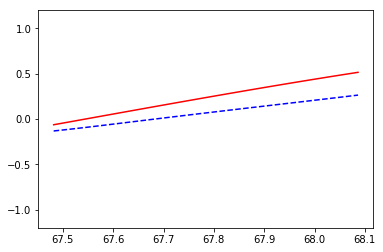

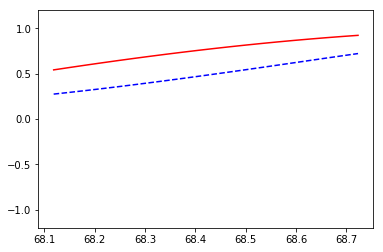

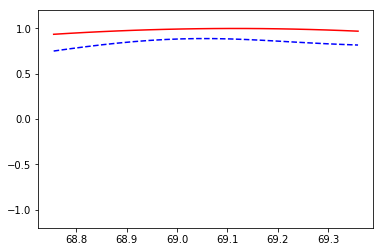

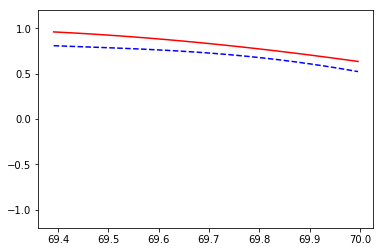

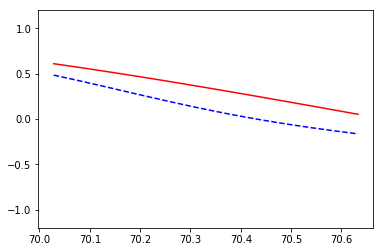

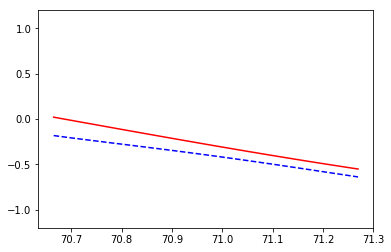

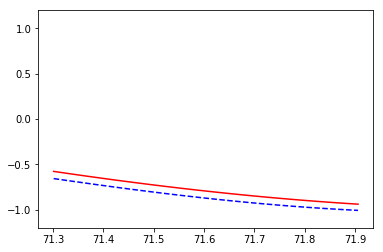

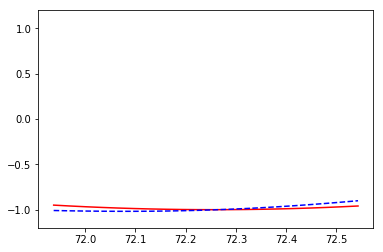

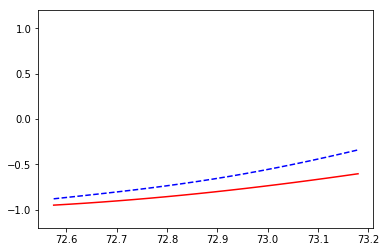

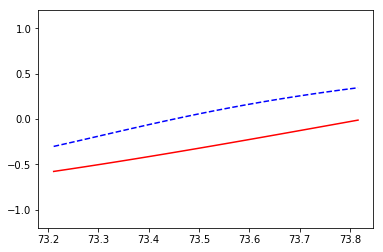

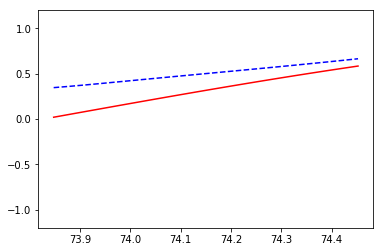

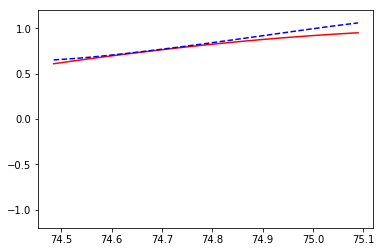

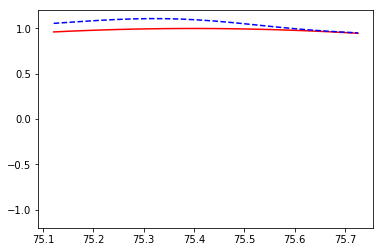

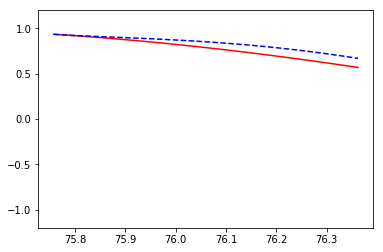

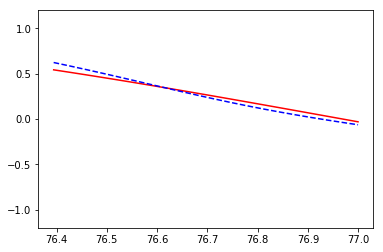

cost:  0.3036


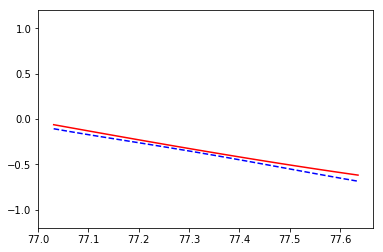

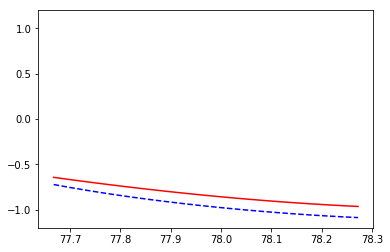

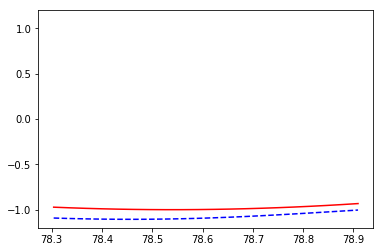

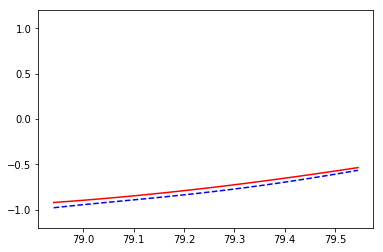

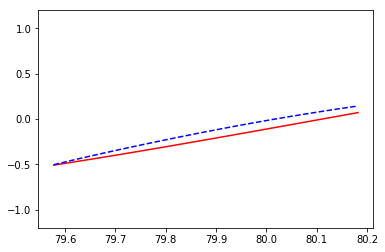

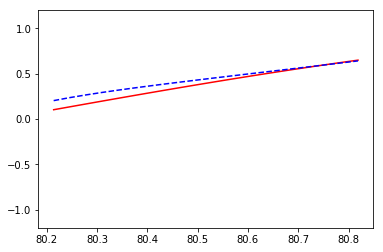

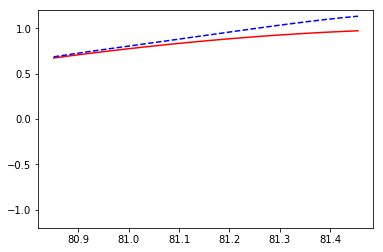

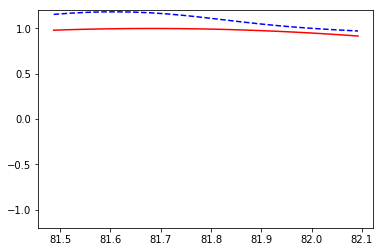

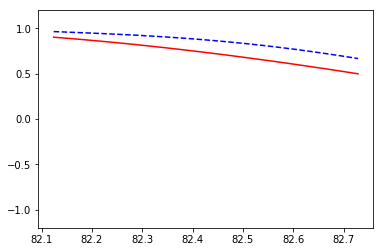

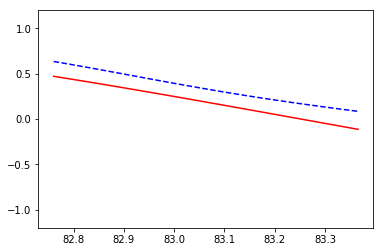

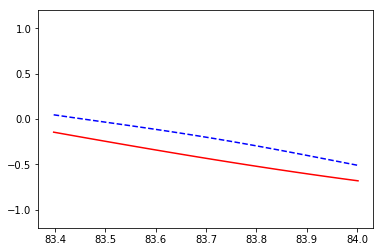

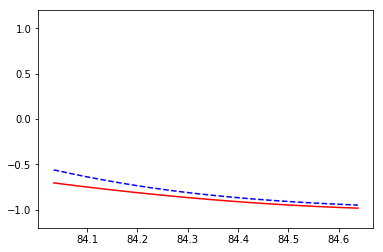

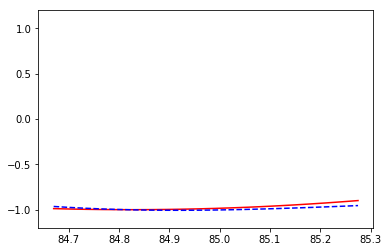

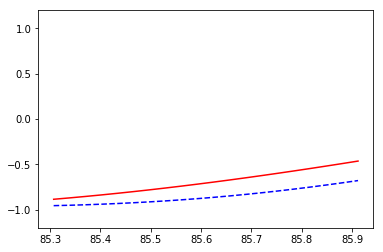

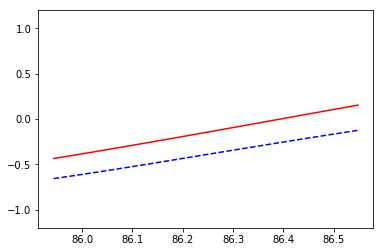

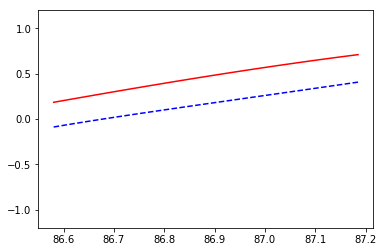

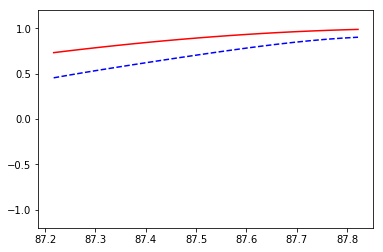

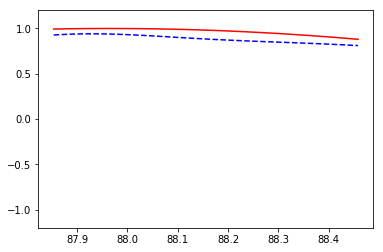

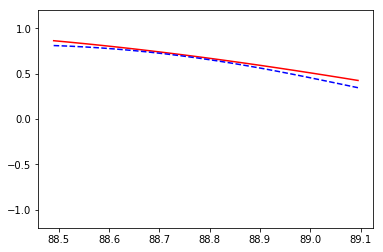

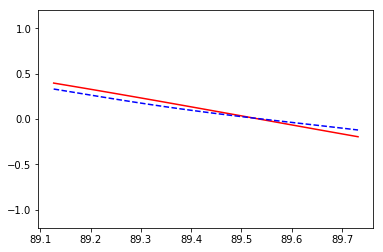

cost:  0.165


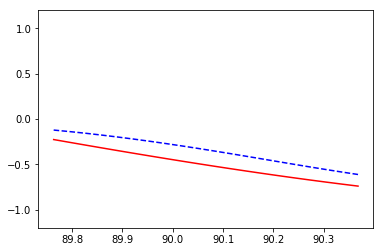

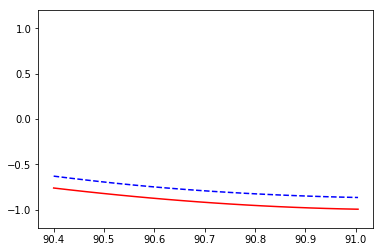

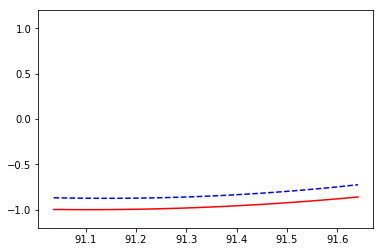

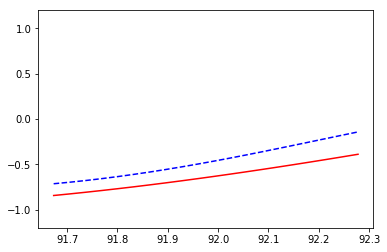

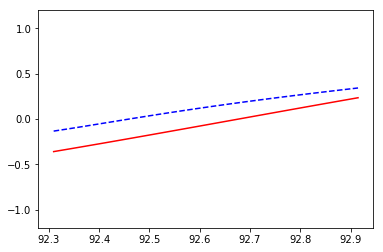

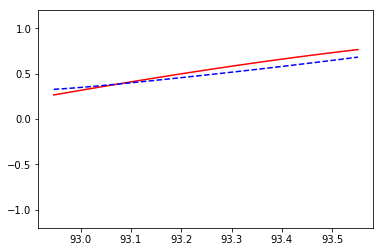

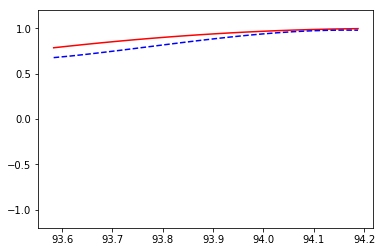

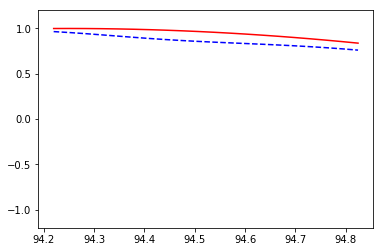

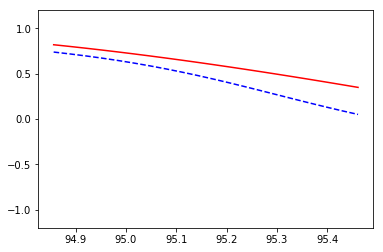

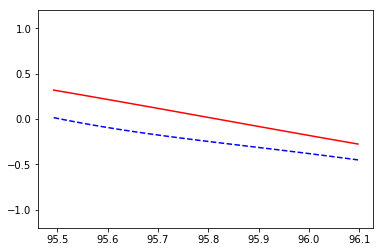

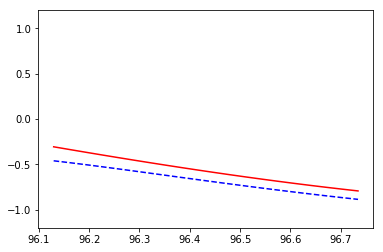

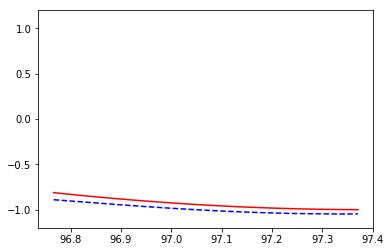

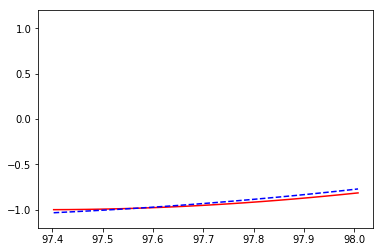

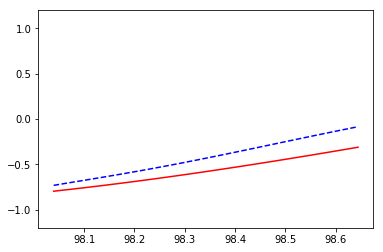

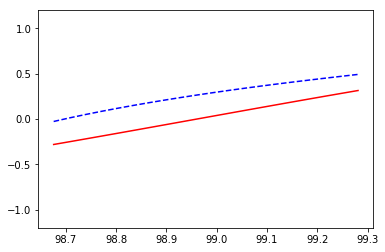

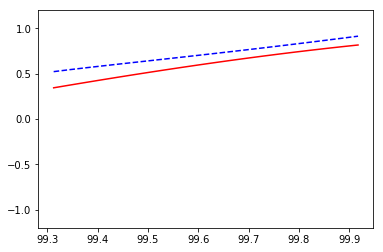

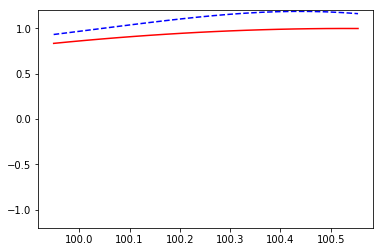

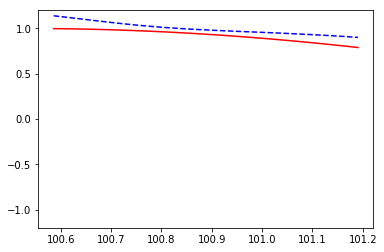

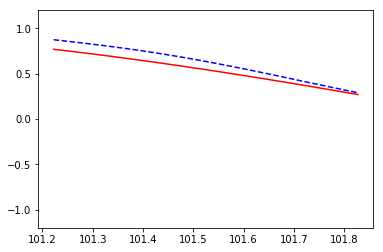

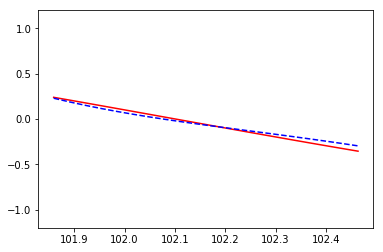

cost:  0.0529


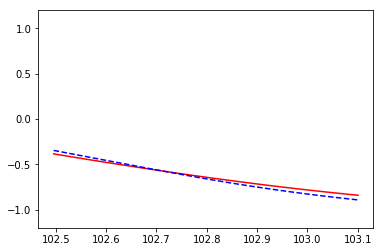

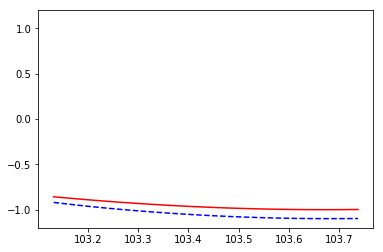

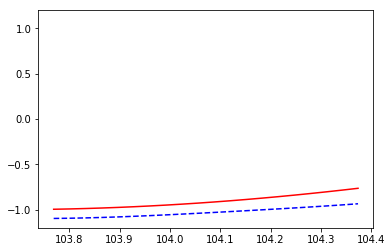

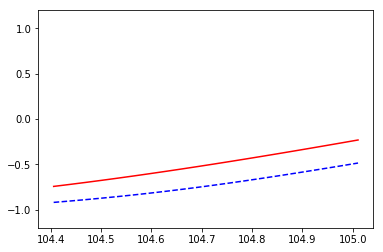

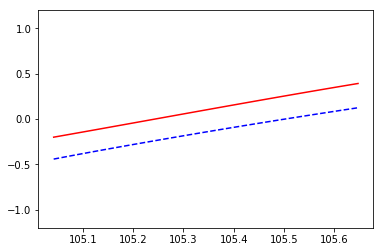

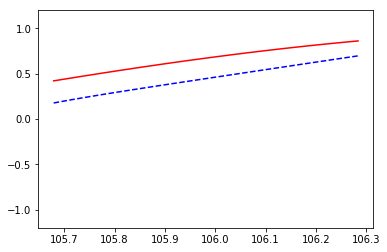

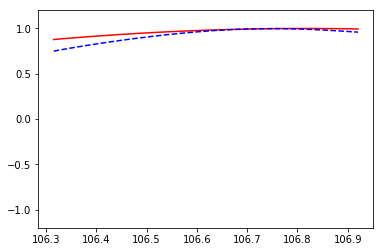

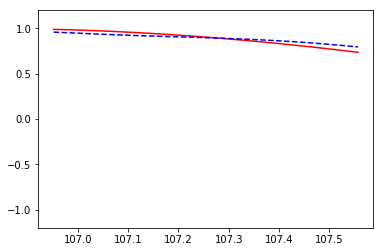

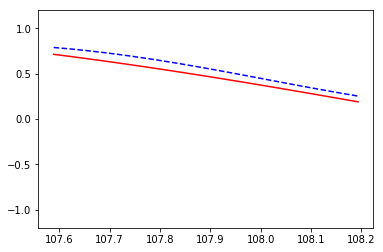

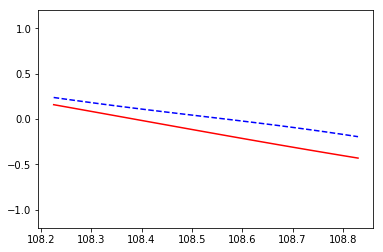

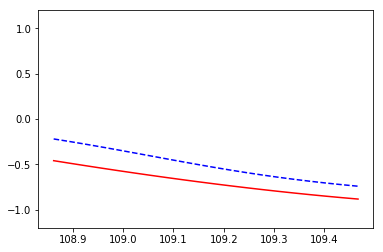

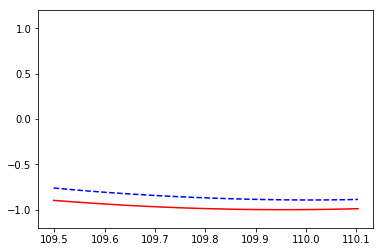

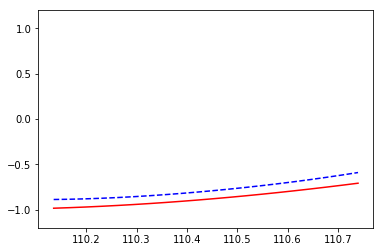

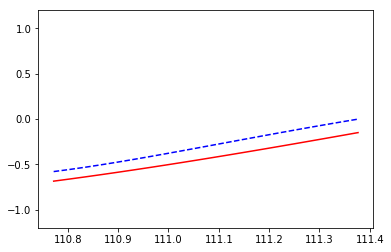

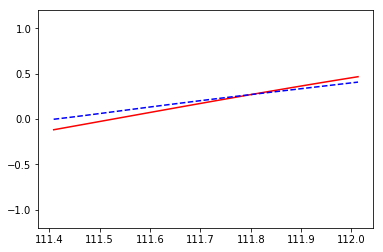

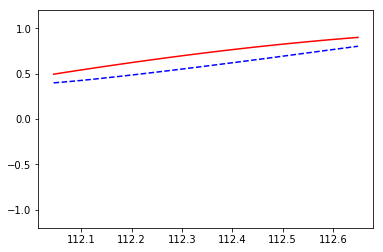

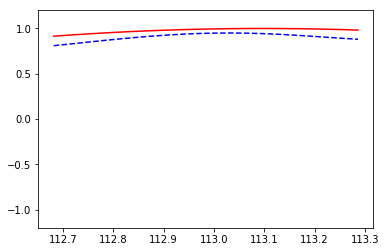

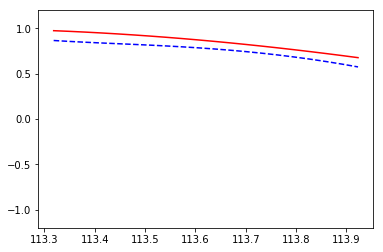

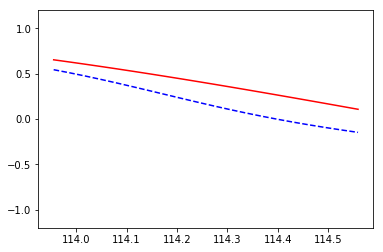

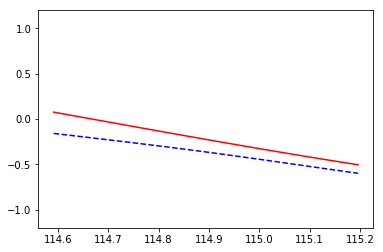

cost:  0.519


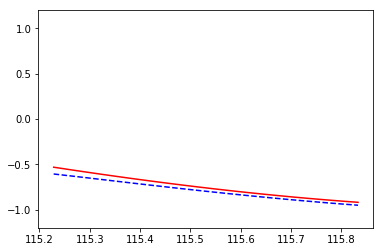

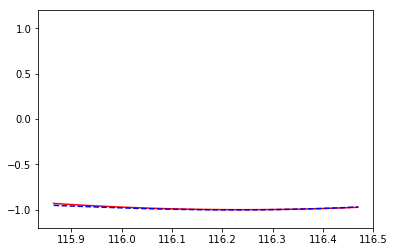

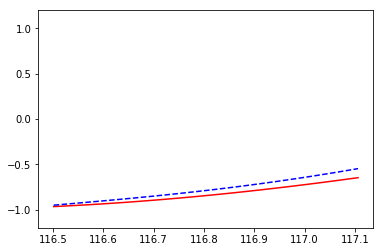

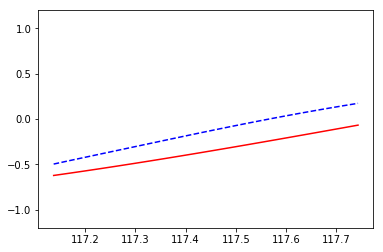

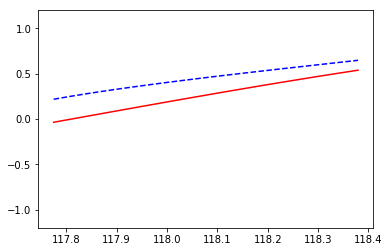

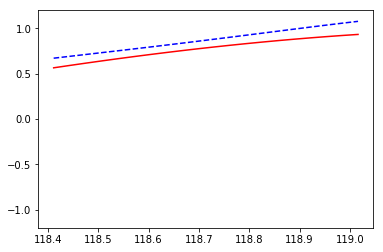

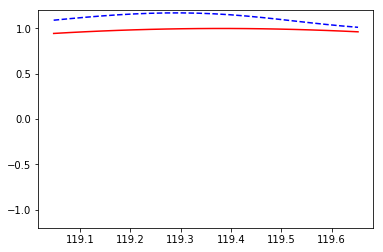

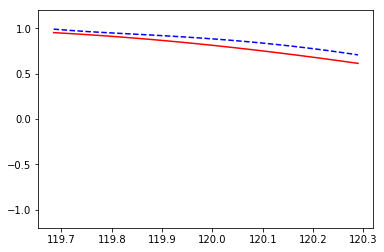

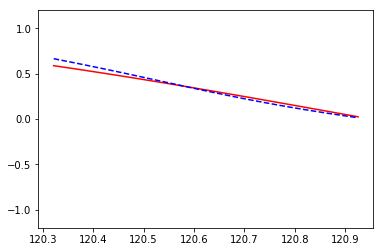

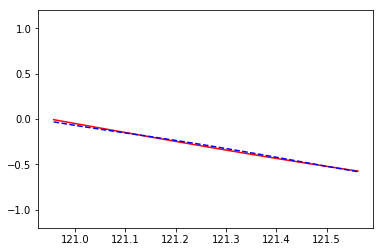

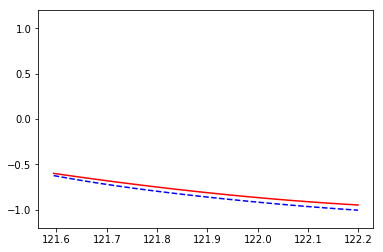

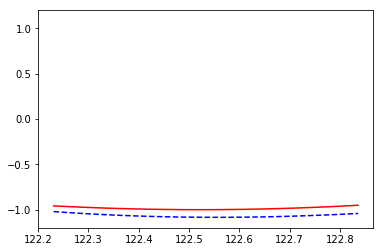

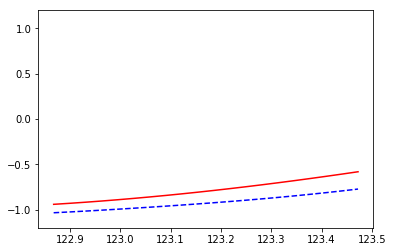

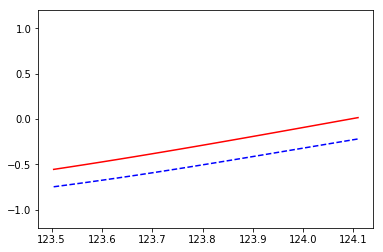

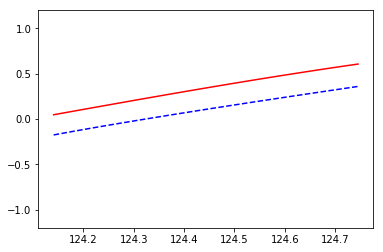

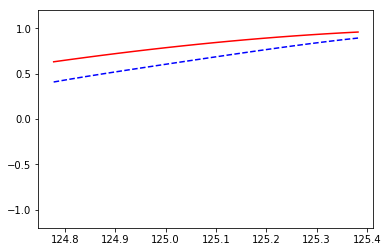

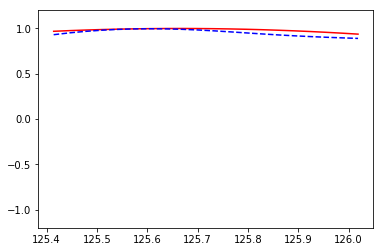

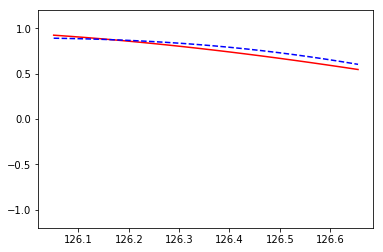

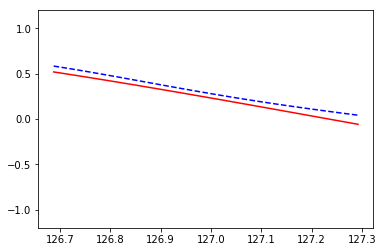

In [3]:
# View more python learning tutorial on my Youtube and Youku channel!!!

# Youtube video tutorial: https://www.youtube.com/channel/UCdyjiB5H8Pu7aDTNVXTTpcg
# Youku video tutorial: http://i.youku.com/pythontutorial

"""
Please note, this code is only for python 3+. If you are using python 2+, please modify the code accordingly.
Run this script on tensorflow r0.10. Errors appear when using lower versions.
"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


BATCH_START = 0
TIME_STEPS = 20
BATCH_SIZE = 50
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CELL_SIZE = 10
LR = 0.006


def get_batch():
    global BATCH_START, TIME_STEPS
    # xs shape (50batch, 20steps)
    xs = np.arange(BATCH_START, BATCH_START+TIME_STEPS*BATCH_SIZE).reshape((BATCH_SIZE, TIME_STEPS)) / (10*np.pi)
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START += TIME_STEPS
    # plt.plot(xs[0, :], res[0, :], 'r', xs[0, :], seq[0, :], 'b--')
    # plt.show()
    # returned seq, res and xs: shape (batch, step, input)
    return [seq[:, :, np.newaxis], res[:, :, np.newaxis], xs]


class LSTMRNN(object):
    def __init__(self, n_steps, input_size, output_size, cell_size, batch_size):
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size
        with tf.name_scope('inputs'):
            self.xs = tf.placeholder(tf.float32, [None, n_steps, input_size], name='xs')
            self.ys = tf.placeholder(tf.float32, [None, n_steps, output_size], name='ys')
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell'):
            self.add_cell()
        with tf.variable_scope('out_hidden'):
            self.add_output_layer()
        with tf.name_scope('cost'):
            self.compute_cost()
        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(LR).minimize(self.cost)

    def add_input_layer(self,):
        l_in_x = tf.reshape(self.xs, [-1, self.input_size], name='2_2D')  # (batch*n_step, in_size)
        # Ws (in_size, cell_size)
        Ws_in = self._weight_variable([self.input_size, self.cell_size])
        # bs (cell_size, )
        bs_in = self._bias_variable([self.cell_size,])
        # l_in_y = (batch * n_steps, cell_size)
        with tf.name_scope('Wx_plus_b'):
            l_in_y = tf.matmul(l_in_x, Ws_in) + bs_in
        # reshape l_in_y ==> (batch, n_steps, cell_size)
        self.l_in_y = tf.reshape(l_in_y, [-1, self.n_steps, self.cell_size], name='2_3D')

    def add_cell(self):
        lstm_cell = tf.contrib.rnn.BasicLSTMCell(self.cell_size, forget_bias=1.0, state_is_tuple=True)
        with tf.name_scope('initial_state'):
            self.cell_init_state = lstm_cell.zero_state(self.batch_size, dtype=tf.float32)
        self.cell_outputs, self.cell_final_state = tf.nn.dynamic_rnn(
            lstm_cell, self.l_in_y, initial_state=self.cell_init_state, time_major=False)

    def add_output_layer(self):
        # shape = (batch * steps, cell_size)
        l_out_x = tf.reshape(self.cell_outputs, [-1, self.cell_size], name='2_2D')
        Ws_out = self._weight_variable([self.cell_size, self.output_size])
        bs_out = self._bias_variable([self.output_size, ])
        # shape = (batch * steps, output_size)
        with tf.name_scope('Wx_plus_b'):
            self.pred = tf.matmul(l_out_x, Ws_out) + bs_out

    def compute_cost(self):
        losses = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
            [tf.reshape(self.pred, [-1], name='reshape_pred')],
            [tf.reshape(self.ys, [-1], name='reshape_target')],
            [tf.ones([self.batch_size * self.n_steps], dtype=tf.float32)],
            average_across_timesteps=True,
            softmax_loss_function=self.ms_error,
            name='losses'
        )
        with tf.name_scope('average_cost'):
            self.cost = tf.div(
                tf.reduce_sum(losses, name='losses_sum'),
                self.batch_size,
                name='average_cost')
            tf.summary.scalar('cost', self.cost)

    @staticmethod
    def ms_error(labels, logits):
        return tf.square(tf.subtract(labels, logits))

    def _weight_variable(self, shape, name='weights'):
        initializer = tf.random_normal_initializer(mean=0., stddev=1.,)
        return tf.get_variable(shape=shape, initializer=initializer, name=name)

    def _bias_variable(self, shape, name='biases'):
        initializer = tf.constant_initializer(0.1)
        return tf.get_variable(name=name, shape=shape, initializer=initializer)


if __name__ == '__main__':
    model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, BATCH_SIZE)
    sess = tf.Session()
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("logs", sess.graph)
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    # relocate to the local dir and run this line to view it on Chrome (http://0.0.0.0:6006/):
    # $ tensorboard --logdir='logs'

    plt.ion()
    plt.show()
    for i in range(200):
        seq, res, xs = get_batch()
        if i == 0:
            feed_dict = {
                    model.xs: seq,
                    model.ys: res,
                    # create initial state
            }
        else:
            feed_dict = {
                model.xs: seq,
                model.ys: res,
                model.cell_init_state: state    # use last state as the initial state for this run
            }

        _, cost, state, pred = sess.run(
            [model.train_op, model.cost, model.cell_final_state, model.pred],
            feed_dict=feed_dict)

        # plotting
        plt.plot(xs[0, :], res[0].flatten(), 'r', xs[0, :], pred.flatten()[:TIME_STEPS], 'b--')
        plt.ylim((-1.2, 1.2))
        plt.draw()
        plt.pause(0.3)

        if i % 20 == 0:
            print('cost: ', round(cost, 4))
            result = sess.run(merged, feed_dict)
            writer.add_summary(result, i)